In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import interp1d
import pandas as pd
import wfdb
import os

Step 1: Amplitude Normalization

In [4]:
def amplitude_normalization(signal):
    return signal / np.max(np.abs(signal))

Step 2: Bandpass Filtering (Preprocessing)

In [5]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

Step 3: R-peak Detection using Adaptive Threshold

In [6]:
def detect_r_peaks(signal, fs):
    # Find peaks using scipy's find_peaks
    peaks, _ = find_peaks(signal, height=np.mean(signal), distance=fs * 0.6)
    return peaks

Step 4: R-R Interval and Heart Rate Calculation

In [7]:
def calculate_rr_intervals_and_heart_rate(r_peaks, fs):
    rr_intervals = np.diff(r_peaks) / fs  # In seconds
    avg_rr_interval = np.mean(rr_intervals)
    heart_rate = 60 / avg_rr_interval  # Beats per minute
    return rr_intervals, heart_rate

Step 5: Heart Rate Variability (HRV) Calculation

In [8]:
def calculate_hrv(rr_intervals):
    hrv = (np.max(rr_intervals) - np.min(rr_intervals)) * 100
    return hrv

Step 6: QRS Complex Detection using Pan-Tompkins Algorithm

In [9]:
def pan_tompkins_qrs_detection(signal, fs):
    # Bandpass filter
    filtered_signal = butter_bandpass_filter(signal, 5, 15, fs, order=2)
    
    # Differentiation
    diff_signal = np.diff(filtered_signal)
    
    # Squaring
    squared_signal = diff_signal ** 2
    
    # Moving window integration
    window_size = int(0.15 * fs)
    integrated_signal = np.convolve(squared_signal, np.ones(window_size) / window_size)
    
    # Thresholding
    threshold = 0.5 * np.max(integrated_signal)
    qrs_peaks, _ = find_peaks(integrated_signal, height=threshold)
    
    return qrs_peaks

Q and S Peak Detection

In [10]:
def detect_qs_peaks(signal, r_peaks):
    q_peaks = []
    s_peaks = []
    
    for r in r_peaks:
        # Q peak: First local minimum to the left of R
        q_window = signal[max(0, r - 50):r]
        q_peak = np.argmin(q_window) + max(0, r - 50)
        q_peaks.append(q_peak)
        
        # S peak: First local minimum to the right of R
        s_window = signal[r:min(len(signal), r + 50)]
        s_peak = np.argmin(s_window) + r
        s_peaks.append(s_peak)
    
    return np.array(q_peaks), np.array(s_peaks)

Step 8: P and T Peak Detection using Moving Window

In [11]:
def detect_pt_peaks(signal, r_peaks, fs):
    p_peaks = []
    t_peaks = []
    
    for r in r_peaks:
        # P peak: Before R (left window)
        p_window = signal[max(0, r - int(0.2 * fs)):r]
        p_peak = np.argmax(p_window) + max(0, r - int(0.2 * fs))
        p_peaks.append(p_peak)
        
        # T peak: After R (right window)
        t_window = signal[r:min(len(signal), r + int(0.4 * fs))]
        t_peak = np.argmax(t_window) + r
        t_peaks.append(t_peak)
    
    return np.array(p_peaks), np.array(t_peaks)

Step 9: Calculate R to P Ratio

In [12]:
def calculate_r_to_p_ratio(r_peaks, p_peaks, signal):
    r_amplitudes = signal[r_peaks]
    p_amplitudes = signal[p_peaks]
    r_to_p_ratio = np.mean(r_amplitudes / p_amplitudes)
    return r_to_p_ratio

Step 10: Calculate Segments and Intervals

In [13]:
def calculate_segments_and_intervals(p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, fs):
    # PR Interval (P start to R start)
    pr_intervals = (r_peaks - p_peaks) / fs
    
    # QRS Duration (Q start to S end)
    qrs_durations = (s_peaks - q_peaks) / fs
    
    # ST Segment (S end to T start)
    st_segments = (t_peaks - s_peaks) / fs
    
    # QT Interval (Q start to T end)
    qt_intervals = (t_peaks - q_peaks) / fs
    
    return pr_intervals, qrs_durations, st_segments, qt_intervals

Heart Rate: 73.85 BPM
HRV: 0.27778
R to P Ratio: 1.06042
PR Intervals: 0.00278 s
QRS Durations: 0.04722 s
ST Segments: -0.02222 s
QT Intervals: 0.02500 s


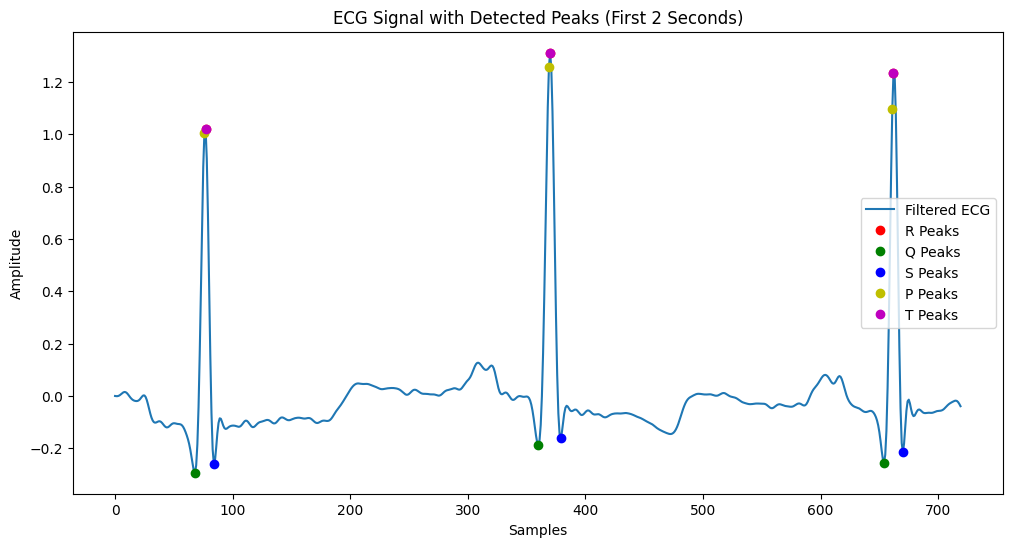

In [35]:
def main():
    # Load ECG signal from a .dat file
    record_name = '100'  # Replace with your .dat file name (without extension)
    record_path = ''  # Replace with the directory containing the .dat file
    
    # Construct the full path to the .dat file
    full_path = os.path.join(record_path, record_name)
    
    # Read the .dat file using wfdb
    try:
        record = wfdb.rdrecord(full_path)
        ecg_signal = record.p_signal[:, 0]  # Assuming the first channel contains the ECG signal
        fs = record.fs  # Sampling frequency from the header file
    except FileNotFoundError:
        print(f"Error: File not found at {full_path}. Please check the file path and name.")
        return
    
    # Crop the signal to the first 120 seconds
    samp_sec = 2
    # num_samples = int(120 * fs)  # Number of samples in 120 seconds
    num_samples = int(samp_sec * fs) # Number of samples in 60 seconds
    if len(ecg_signal) < num_samples:
        print(f"Warning: The signal is shorter than 120 seconds. Using the entire signal.")
        num_samples = len(ecg_signal)
    ecg_signal = ecg_signal[:num_samples]
    
    # Step 1: Amplitude Normalization
    normalized_signal = amplitude_normalization(ecg_signal)
    
    # Step 2: Preprocessing (Bandpass Filtering)
    filtered_signal = butter_bandpass_filter(normalized_signal, 0.5, 40, fs)
    
    # Step 3: R-peak Detection
    r_peaks = detect_r_peaks(filtered_signal, fs)
    
    # Step 4: R-R Interval and Heart Rate
    rr_intervals, heart_rate = calculate_rr_intervals_and_heart_rate(r_peaks, fs)
    
    # Step 5: HRV Calculation
    hrv = calculate_hrv(rr_intervals)
    
    # Step 6: QRS Complex Detection
    qrs_peaks = pan_tompkins_qrs_detection(filtered_signal, fs)
    
    # Step 7: Q and S Peak Detection
    q_peaks, s_peaks = detect_qs_peaks(filtered_signal, r_peaks)
    
    # Step 8: P and T Peak Detection
    p_peaks, t_peaks = detect_pt_peaks(filtered_signal, r_peaks, fs)
    
    # Step 9: R to P Ratio
    r_to_p_ratio = calculate_r_to_p_ratio(r_peaks, p_peaks, filtered_signal)
    
    # Step 10: Segments and Intervals
    pr_intervals, qrs_durations, st_segments, qt_intervals = calculate_segments_and_intervals(
        p_peaks, q_peaks, r_peaks, s_peaks, t_peaks, fs)
    
    # Print Results
    print(f"Heart Rate: {heart_rate:.2f} BPM")
    print(f"HRV: {hrv:.5f}")
    print(f"R to P Ratio: {r_to_p_ratio:.5f}")
    print(f"PR Intervals: {np.mean(pr_intervals):.5f} s")
    print(f"QRS Durations: {np.mean(qrs_durations):.5f} s")
    print(f"ST Segments: {np.mean(st_segments):.5f} s")
    print(f"QT Intervals: {np.mean(qt_intervals):.5f} s")
    
    # Plot ECG Signal with Detected Peaks
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_signal, label='Filtered ECG')
    plt.plot(r_peaks, filtered_signal[r_peaks], 'ro', label='R Peaks')
    plt.plot(q_peaks, filtered_signal[q_peaks], 'go', label='Q Peaks')
    plt.plot(s_peaks, filtered_signal[s_peaks], 'bo', label='S Peaks')
    plt.plot(p_peaks, filtered_signal[p_peaks], 'yo', label='P Peaks')
    plt.plot(t_peaks, filtered_signal[t_peaks], 'mo', label='T Peaks')
    plt.legend()
    plt.title(f'ECG Signal with Detected Peaks (First {samp_sec} Seconds)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.show()

if __name__ == "__main__":
    main()